## Learning Objectives

At the end of the experiment, you will be able to:

* perform different text processing techniques
* train and evaluate NaiveBayes classification model
* predict the sentiment ('positive' or 'negative') for a movie reviews dataset using the sklearn machine learning library
* generate customizable UI using gradio library


## Information

**Naïve Bayes’ Classifier**

Bayesian network classifiers are a popular supervised
classification paradigm. The Naïve Bayes’ classifier is a probabilistic
classifier based on the Bayes’ theorem, considering
Naïve (Strong) independence assumption.
It is a popular(baseline) method for text categorizing, with word frequencies as the feature.

An advantage of Naïve Bayes’ is that it
only requires a small amount of training data to
estimate the parameters necessary for classification. Despite its simplicity and strong assumptions, the
Naïve Bayes’ classifier has been proven to work
satisfactorily in many domains. Bayesian classification
provides practical learning algorithms and prior knowledge and observed data can be combined. In Naïve Bayes’ technique, the basic idea is to find the
probabilities of categories given a text document by
using the joint probabilities of words and categories. It is based on the assumption of word independence.

### Importing Required Packages

In [54]:
!pip -qq install gradio

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer                        # to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text
from sklearn.feature_extraction.text import TfidfVectorizer                        # to transform text into a term and document frequency based representation of numbers
import nltk                                                                        # platform for building Python programs to process natural language
nltk.download('stopwords')                                                         # to download the stop words
nltk.download('punkt')                                                             # tokenizer divides a text into a list of sentences, by using an unsupervised algorithm to build a model for abbreviation words, collocations, and words that start sentences
from nltk.corpus import stopwords                                                  # importing the NTLK stopwords to remove articles, preposition and other words that are not actionable
from nltk.stem.porter import PorterStemmer                                         # process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words
from wordcloud import WordCloud                                                    # visualization of words based on their frequency
from nltk.tokenize import word_tokenize                                            # allows to create individual objects from a bag of words
from bs4 import BeautifulSoup                                                      # Python library for pulling data from HTML and XML files
import re                                                                          # regular expression (or RE) specifies a set of strings that matches it
from sklearn.naive_bayes import MultinomialNB                                      # to import multinomial naive bayes which is suitable for classification with discrete features (e.g., word counts for text classification)
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score  # to import metrics for evaluating the classification model
from sklearn.model_selection import train_test_split
import gradio
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Dataset description

The [IMDB Movie Reviews dataset](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) is a binary sentiment analysis dataset consisting of 50,000 reviews from the Internet Movie Database (IMDb) labeled as positive or negative. The dataset contains an even number of positive and negative reviews. Only highly polarizing reviews are considered. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. No more than 30 reviews are included per movie. The dataset contains additional unlabeled data.

### **Once you download the above dataset, open in a text editor and regex replace **


*   ',positive\$' with '+positive'
*   ',negative\$' with '+negative'
*   ',sentiment\$ with +sentiment



In [59]:
# read the dataset
import csv
df = pd.read_csv('IMDB Dataset.csv',  quoting=3, on_bad_lines='skip', delimiter='+')
print(df.shape)
df.head(2)      # first 10 rows

(49540, 2)


,review,sentiment
0,"""One of the other reviewers has mentioned that...",positive
1,"""A wonderful little production. <br /><br />Th...",positive


### Exploratory Data Analysis

In [60]:
# summary of the dataset
df.describe()

,review,sentiment
count,49540,49540
unique,49124,2
top,"""Loved today's show!!! It was a variety and no...",negative
freq,5,24775


Now, we will look at the sentiment count.

In [16]:
# df.review = df.review.astype(str)

In [61]:
# sentiment count
df['sentiment'].value_counts()

sentiment
negative    24775
positive    24765
Name: count, dtype: int64

We can see that the dataset is balanced.

Now, we will do the text cleaning of the reviews.



### Text Cleaning

The data scraped from the website is mostly in the raw text form. This data needs to be cleaned before analyzing it or fitting a model to it. Cleaning up the text data is necessary to highlight the attributes that we are going to want our machine learning system to pick up on.

**Removing html strips and noise text**

Sample noise removal tasks could include:

* removing text file headers, footers
* removing HTML, XML, etc. markup and metadata
* extracting valuable data from other formats, such as JSON

In [62]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [63]:
# removing the html strips
def strip_html(text):
    # BeautifulSoup is a useful library for extracting data from HTML and XML documents
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
# apply function on review column
df['review'] = df['review'].apply(denoise_text)

**Removing special characters**

Special characters typically include any character that is not a letter or number, such as punctuation and whitespace. Removing special characters from a string results in a string containing only letters and numbers.

In [64]:
# define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text
# apply function on review column
df['review'] = df['review'].apply(remove_special_characters)

**Text Stemming**

Stemming, also called suffix stripping, is a technique used to reduce text dimensionality. Stemming is also a type of text normalization that enables you to standardize some words into specific expressions also called stems.

In [65]:
# stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
# apply function on review column
df['review'] = df['review'].apply(simple_stemmer)

**Removing stopwords**

Stopwords are English words that do not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc.

In [66]:
# setting english stopwords
stopword_list = nltk.corpus.stopwords.words('english')
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [67]:
# set stopwords to english
stop = set(stopwords.words('english'))
print(stop)

# removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    # splitting strings into tokens (list of words)
    tokens = word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        # filtering out the stop words
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
# apply function on review column
df['review'] = df['review'].apply(remove_stopwords)

{'after', 'now', 'ain', 'your', "haven't", 'my', 'being', 'yourselves', 'other', 'above', 's', 'll', 'haven', "mightn't", "weren't", 'once', 'as', 'most', 'until', 'for', 'own', 'this', 'while', 'weren', 'we', 'a', "shan't", 'from', 'where', 'y', 'them', 'off', 'through', 'these', 'who', 'having', 'same', 'were', 'both', 'our', 'hadn', 'down', 'each', 'about', 'and', 'd', "couldn't", 'is', 'more', 'against', 'ourselves', "aren't", "didn't", 'or', 'she', 'themselves', 'with', 'whom', 'ours', "mustn't", 'be', "it's", 'has', 'too', 'very', 'yourself', 'that', 'the', 'again', 'isn', 'by', 'if', 'him', 'himself', 'ma', 'during', 'are', 'but', 'should', 'so', "shouldn't", 'below', 'wouldn', 'he', 'at', 'into', 'will', 'an', 'then', 'such', 'yours', 'won', 'm', 'myself', 'shan', 'because', 'did', 'didn', 'can', 'o', "needn't", 'when', "you'll", "wouldn't", 't', 'they', 'only', 'does', 'some', 'before', 'nor', 'herself', 've', "she's", 'here', 'have', 'don', 'her', 'couldn', 'what', "you've", 

After cleaning the reviews, we now split the clean dataset into training and testing set.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df.review, df.sentiment, test_size = 0.2, random_state = 0)

**Parameters in train_test_split**

* arrays sequence of indexables with same length / shape (here, df.review and df.sentiment):
Allowed inputs are lists, numpy arrays, scipy-sparse matrices or pandas dataframes.

* test_size (float or int, default=None): The proportion of the dataset to include in the test split If train_size is also None, it will be set to 0.25.


* RandomState:
Controls the shuffling applied to the data before applying the split.

In [69]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(39632,)
(9908,)
(39632,)
(9908,)


Let us see positive and negative words by using **WordCloud**.

A word cloud (also called tag cloud or weighted list) is a visual representation of text data. Words are usually single words, and the importance of each is shown with font size or color.



<function matplotlib.pyplot.show(close=None, block=None)>

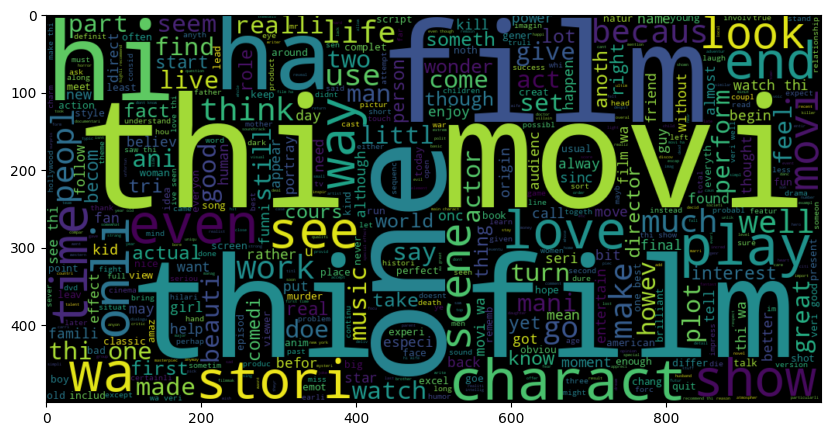

In [70]:
# Word cloud for positive review words

plt.figure(figsize=(10,10))
df_positive_review =  df[df['sentiment']=='positive']
positive_text = ' '.join(review for review in df_positive_review.review)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
positive_words = WC.generate(positive_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

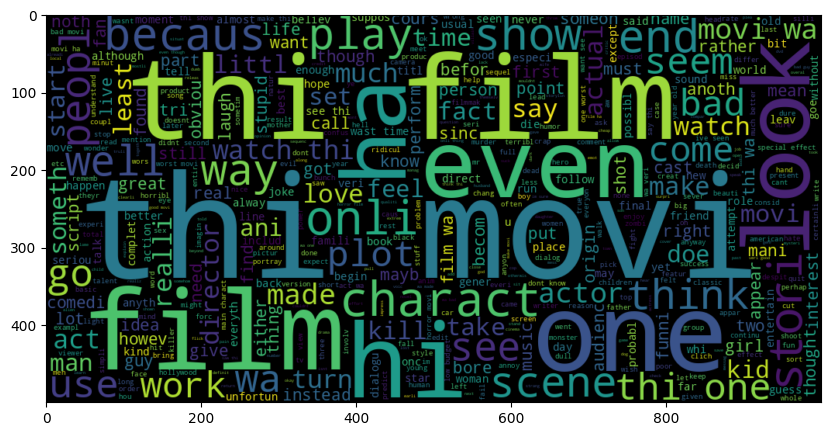

In [71]:
# Word cloud for negative review words

plt.figure(figsize=(10,10))
df_negative_review =  df[df['sentiment']=='negative']
negative_text = ' '.join(review for review in df_negative_review.review)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
negative_words = WC.generate(negative_text)
plt.imshow(negative_words, interpolation='bilinear')
plt.show

#### Count Vectorizer

The `CountVectorizer` provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document. The vectors returned from a call to transform() will be sparse vectors, and we can transform them back to numpy arrays to look and better understand what is going on by calling the `toarray()` function.

To know more about CountVectorizer, click [here](https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c).

In [72]:
# Count vectorizer
cv = CountVectorizer(min_df=0, max_df=1, binary=False, ngram_range=(1,3))
# transformed train reviews
cv_train_reviews = cv.fit_transform(X_train)
# transformed test reviews
cv_test_reviews = cv.transform(X_test)
print('CV_train:', cv_train_reviews.shape)
print('CV_test:', cv_test_reviews.shape)

CV_train: (39632, 6151004)
CV_test: (9908, 6151004)


#### Term Frequency-Inverse Document Frequency (TF-IDF)

It is used to convert text documents to matrix of tf-idf features.

`TfidfVectorizer` is the base building block of many NLP pipelines. It is a simple technique to vectorize text documents — i.e. transform sentences into arrays of numbers — and use them in subsequent tasks.

To know more about tf-idf, click [here]( https://cdn.iisc.talentsprint.com/CDS/TF-IDF.pdf).

In [73]:
# tfidf vectorizer
tv = TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range = (1,3))
#transformed train reviews
tfidf_train_reviews = tv.fit_transform(X_train)
#transformed test reviews
tfidf_test_reviews = tv.transform(X_test)
print('Tfidf_train:', tfidf_train_reviews.shape)
print('Tfidf_test:', tfidf_test_reviews.shape)

Tfidf_train: (39632, 6151004)
Tfidf_test: (9908, 6151004)


### Modeling the dataset

Naive Bayes classifier for multinomial models.

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

To know more, click [here](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes).

#### **`sklearn library`**

Scikit-learn is a free machine learning library for Python. It features various algorithms like support vector machine, random forests, k-nearest neighbors, NaiveBayes and it also supports Python numerical and scientific libraries like NumPy and SciPy.

In [74]:
# training the model
mnb=MultinomialNB()
# fitting the NaiveBayes for count vectorizer
mnb_cv = mnb.fit(cv_train_reviews, y_train)
print('MultinomialNB for Count Vectorizer :',mnb_cv)
# fitting the NaiveBayes for tfidf features
mnb_tfidf = mnb.fit(tfidf_train_reviews, y_train)
print('MultinomialNB for tf-idf :',mnb_tfidf)

MultinomialNB for Count Vectorizer : MultinomialNB()
MultinomialNB for tf-idf : MultinomialNB()


Here, the model parameters are as follows:

* alpha:
Additive smoothing parameter (0 for no smoothing). In statistics, additive smoothing, also called Laplace smoothing, is a technique used to smooth categorical data. Given a set of observation counts ${\textstyle {\mathbf {x} \ =\ \left\langle x_{1},\,x_{2},\,\ldots ,\,x_{d}\right\rangle }}$ from a $d$-dimensional multinomial distribution with $N$ trials, a "smoothed" version of the counts gives the estimator:

${\hat {\theta }}_{i}={\frac {x_{i}+\alpha }{N+\alpha d}}\qquad (i=1,\ldots ,d)$,

where the smoothed count ${\textstyle {{\hat {x}}_{i}=N{\hat {\theta }}_{i}}}$ and the "pseudocount" $α > 0$ is a smoothing parameter. $α = 0$ corresponds to no smoothing.

* fit_prior:
Whether to learn class prior probabilities or not. If false, a uniform prior will be used.

* class_prior:
Prior probabilities of the classes. If specified the priors are not adjusted according to the data.

**Model performance on test data**

In [75]:
# predicting the model for CountVectorizer
mnb_cv_predict = mnb.predict(cv_test_reviews)
print('predictions for Count Vectorizer :', mnb_cv_predict)

# predicting the model for tfidf features
mnb_tfidf_predict = mnb.predict(tfidf_test_reviews)
print('predictions for tf-idf :', mnb_tfidf_predict)

predictions for Count Vectorizer : ['negative' 'negative' 'positive' ... 'negative' 'positive' 'negative']
predictions for tf-idf : ['negative' 'negative' 'positive' ... 'negative' 'positive' 'negative']


**Accuracy of Model**

It is the ratio of number of correct classifications to the total number of input samples.

In [76]:
# accuracy score for count vectorizer
mnb_cv_score = accuracy_score(y_test, mnb_cv_predict)
print("mnb_cv_score :", mnb_cv_score)

# accuracy score for tf-idf
mnb_tfidf_score = accuracy_score(y_test, mnb_tfidf_predict)
print("mnb_tfidf_score :", mnb_tfidf_score)

mnb_cv_score : 0.7434396447315301
mnb_tfidf_score : 0.7432377876463464


**Plot the confusion matrix**

A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

A confusion matrix, in predictive analytics, is a square matrix that tells us the rate of false positives, false negatives, true positives and true negatives for a test or predictor. We can make a confusion matrix if we know both the predicted values and the true values for a sample set.

In [77]:
# confusion matrix for count vectorizer
cm_cv = confusion_matrix(y_test, mnb_cv_predict, labels=['positive', 'negative'])
print('confusion matrix for count vectorizer :\n', cm_cv)

# confusion matrix for tf-idf
cm_tfidf = confusion_matrix(y_test,mnb_tfidf_predict, labels=['positive','negative'])
print('confusion matrix for tf-idf :\n', cm_tfidf)

confusion matrix for count vectorizer :
 [[3662 1330]
 [1212 3704]]
confusion matrix for tf-idf :
 [[3601 1391]
 [1153 3763]]


In [78]:
# Function for preprocessing of text

def preprocess_text(text):

    text = denoise_text(text)
    text = remove_special_characters(text)
    text = simple_stemmer(text)
    text = remove_stopwords(text)

    return text

In [79]:
# Function to predict label for a review

def predict_review_label(text, vectorizer_method):

    processed_text = preprocess_text(text)

    if vectorizer_method == 'CountVectorizer':
        review = cv.transform([processed_text])
        pred = mnb_cv.predict(review)
    if vectorizer_method == 'TFIDFVectorizer':
        review = tv.transform([processed_text])
        pred = mnb_tfidf.predict(review)
    else:
        review = cv.transform([processed_text])
        pred = mnb_cv.predict(review)

    return pred[0]

In [80]:
# Testing a review
predict_review_label("It was a good movie, really enjoyed it a lot.", 'CountVectorizer')

'negative'

In [81]:
# Testing a review
predict_review_label("Was very bad, I was barely able to understand the concepts.", 'TFIDFVectorizer')

'negative'

### Gradio Implementation

Gradio is an open-source python library that allows us to quickly create easy-to-use, customizable UI components for our ML model, any API, or any arbitrary function in just a few lines of code. We can integrate the GUI directly into the Python notebook, or we can share the link with anyone.

In [84]:
# Dropdown choices
in_vectorizer_dropdown = gradio.components.Dropdown(['CountVectorizer', 'TFIDFVectorizer'], type="value", label='Choose a Method to Vectorize')

In [87]:
# Input from user
in_review = gradio.components.Textbox(lines=2, placeholder=None, label='Enter Review Text')

In [88]:
# Output prediction
out_label = gradio.components.Textbox(type="text", label='Predicted Review Label')

In [89]:
# Gradio interface to generate UI link

iface = gradio.Interface(
  fn = predict_review_label,
  inputs = [in_review, in_vectorizer_dropdown],
  outputs = [out_label])
iface.launch(share=True, debug=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()

Could not create share link. Missing file: /usr/local/lib/python3.10/dist-packages/gradio/frpc_linux_amd64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_linux_amd64
2. Rename the downloaded file to: frpc_linux_amd64_v0.2
3. Move the file to this location: /usr/local/lib/python3.10/dist-packages/gradio


<IPython.core.display.Javascript object>

Click on the link generated above to see UI.